In [1]:
import math
import numpy as np

## Brute Force Order-finding

In [2]:
def order_finding_classical(a, N):
    if (a < 1) or (a >= N) or (N <= 1):
        raise ValueError("The integer a must be in the range 1 <= a <= N-1 and N must be greater than 1.")
    if math.gcd(a, N) != 1:
        raise ValueError("The integer a must be coprime with N.")
    
    def mod_exp(base, exp, mod):
        result = 1
        while exp > 0:
            if exp % 2 == 1:
                result = (result * base) % mod
            base = (base * base) % mod
            exp //= 2
        return result
    
    r = 1
    while mod_exp(a, r, N) != 1:
        r += 1
    return r

In [30]:
print(order_finding_classical(4, 21))

3


## Quantum Order-Finding

##### Importing libraries

In [4]:
#Built-in modules
import math

#imports from Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_distribution, plot_histogram
from qiskit.circuit.library import QFT
import numpy as np
import matplotlib.pyplot as plt

#Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [5]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
backend=AerSimulator()
backend.name

'aer_simulator'

In [23]:
# Check if N=a^b for some a and b
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for _ in range(j):
        a = np.mod(a**2, N)
    return a

In [28]:
def order_finding_quantum(a, N, epsilon):
    if (a < 1) or (a >= N) or (N <= 1):
        raise ValueError("The integer a must be in the range 1 <= a <= N-1 and N must be greater than 1.")
    if math.gcd(a, N) != 1:
        raise ValueError("The integer a must be coprime with N.")
    
    # Find the number of bits needed to represent N
    n = math.ceil(math.log2(N))
    # n_count=2*n+1+math.ceil(math.log2(1+(1/(2*epsilon))))
    # n_count=2*n
    n_count = 8

    # Create the quantum circuit
    
    qr = QuantumRegister(n_count + n, 'q')
    cr = ClassicalRegister(n_count, 'c')
    qc = QuantumCircuit(qr, cr)

    # Initialize the qubits
    qc.h(qr[0:n_count])
    qc.x(qr[n_count + n - 1])

    # Apply the controlled modular multiplication gates
    for q in range(n_count):
        for _ in range(2**q):
            qc.cp(2*np.pi*a2jmodN(a, 2**(n_count-1-q), N), q, n_count)
    
    # Apply the inverse quantum Fourier transform
    qc.append(QFT(n_count).inverse(), qr[0:n_count])

    # Measure the first n qubits
    qc.measure(qr[0:n_count], cr[0:n_count])

    return qc
    

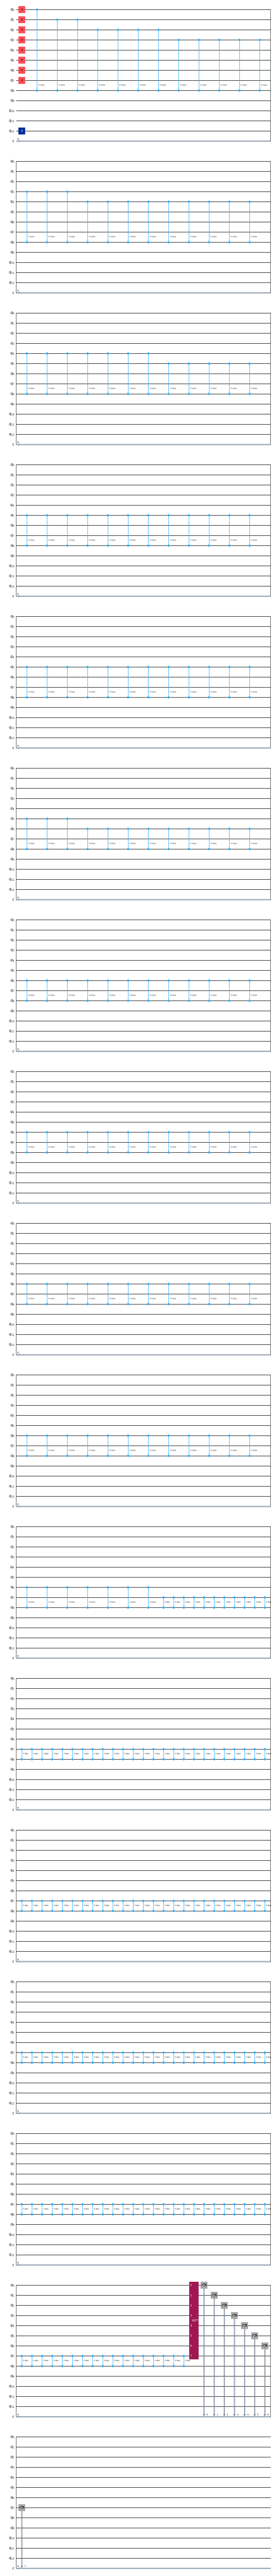

In [29]:
N=21
a=2
circ = order_finding_quantum(a, N, 0.25)
circ.draw('mpl')